In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys-dmm/')
from src.utils.path import find

In [2]:
from scipy.interpolate import interp1d

In [3]:
recording_directory = '/home/niell_lab/data/freely_moving_ephys/ephys_recordings/070921/J553RT/fm1'

In [4]:
df = pd.read_hdf(find('*_ephys_props.h5', recording_directory)[0])
eye = xr.open_dataset(find('*REYE.nc', recording_directory)[0])
eyevid = eye.REYE_video.values
pts = eye.REYE_pts
top = xr.open_dataset(find('*TOP1.nc', recording_directory)[0])
topvid = top.TOP1_video.values
eyeT = df['FmLt_eyeT'].iloc[0]
dEye = df['FmLt_dEye_dps'].iloc[0]
dHead = df['FmLt_dHead'].iloc[0]
dGaze = df['FmLt_dGaze'].iloc[0]
gyro_z = df['FmLt_gyro_z'].iloc[0]
theta = df['FmLt_theta'].iloc[0]
phi = df['FmLt_phi'].iloc[0]
t0 = df['t0'].iloc[0]
topT = df['FmLt_topT'].iloc[0]
eyetime2frame = dict(zip(eyeT + t0, range(len(eyeT))))
neckpos_x = top.TOP1_pts.sel(point_loc='center_neck_x').values
neckpos_y = top.TOP1_pts.sel(point_loc='center_neck_y').values
headang = top.TOP1_props.sel(prop='head_yaw').values # rad
neckpos_x_interp = interp1d(topT, neckpos_x, bounds_error=False)(eyeT)
neckpos_y_interp = interp1d(topT, neckpos_y, bounds_error=False)(eyeT)
headang_interp = interp1d(topT, headang, bounds_error=False)(eyeT)

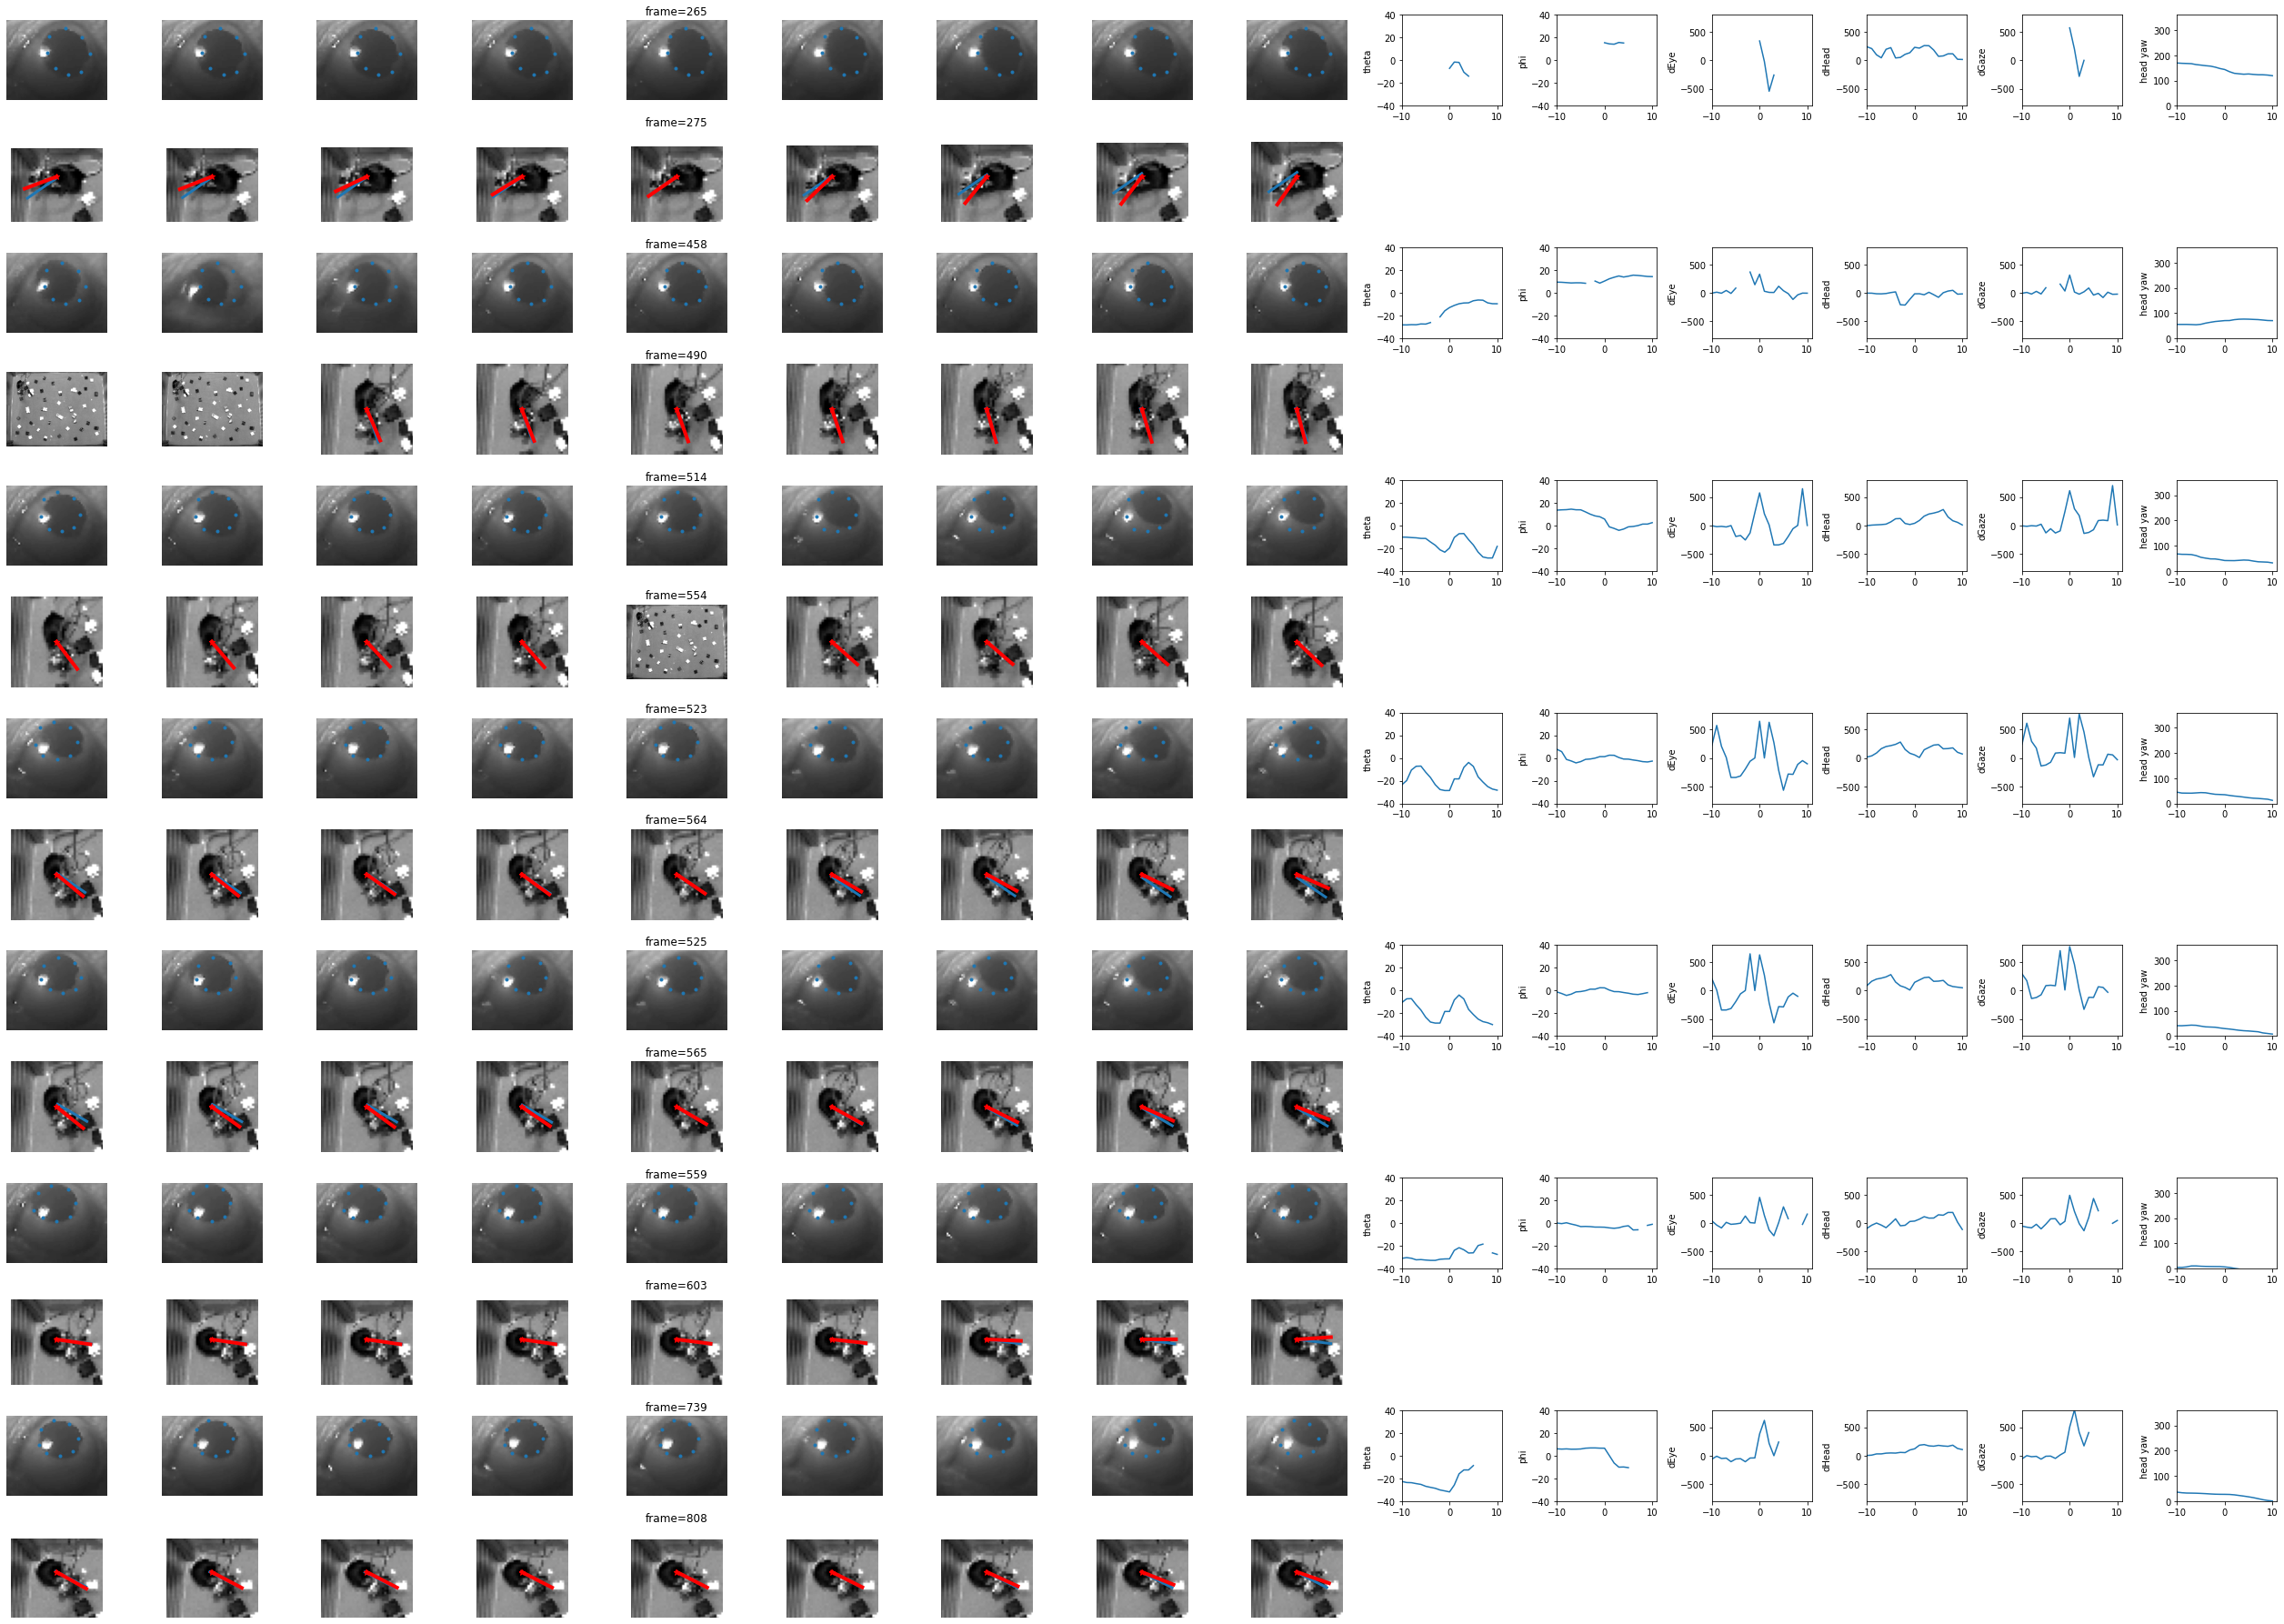

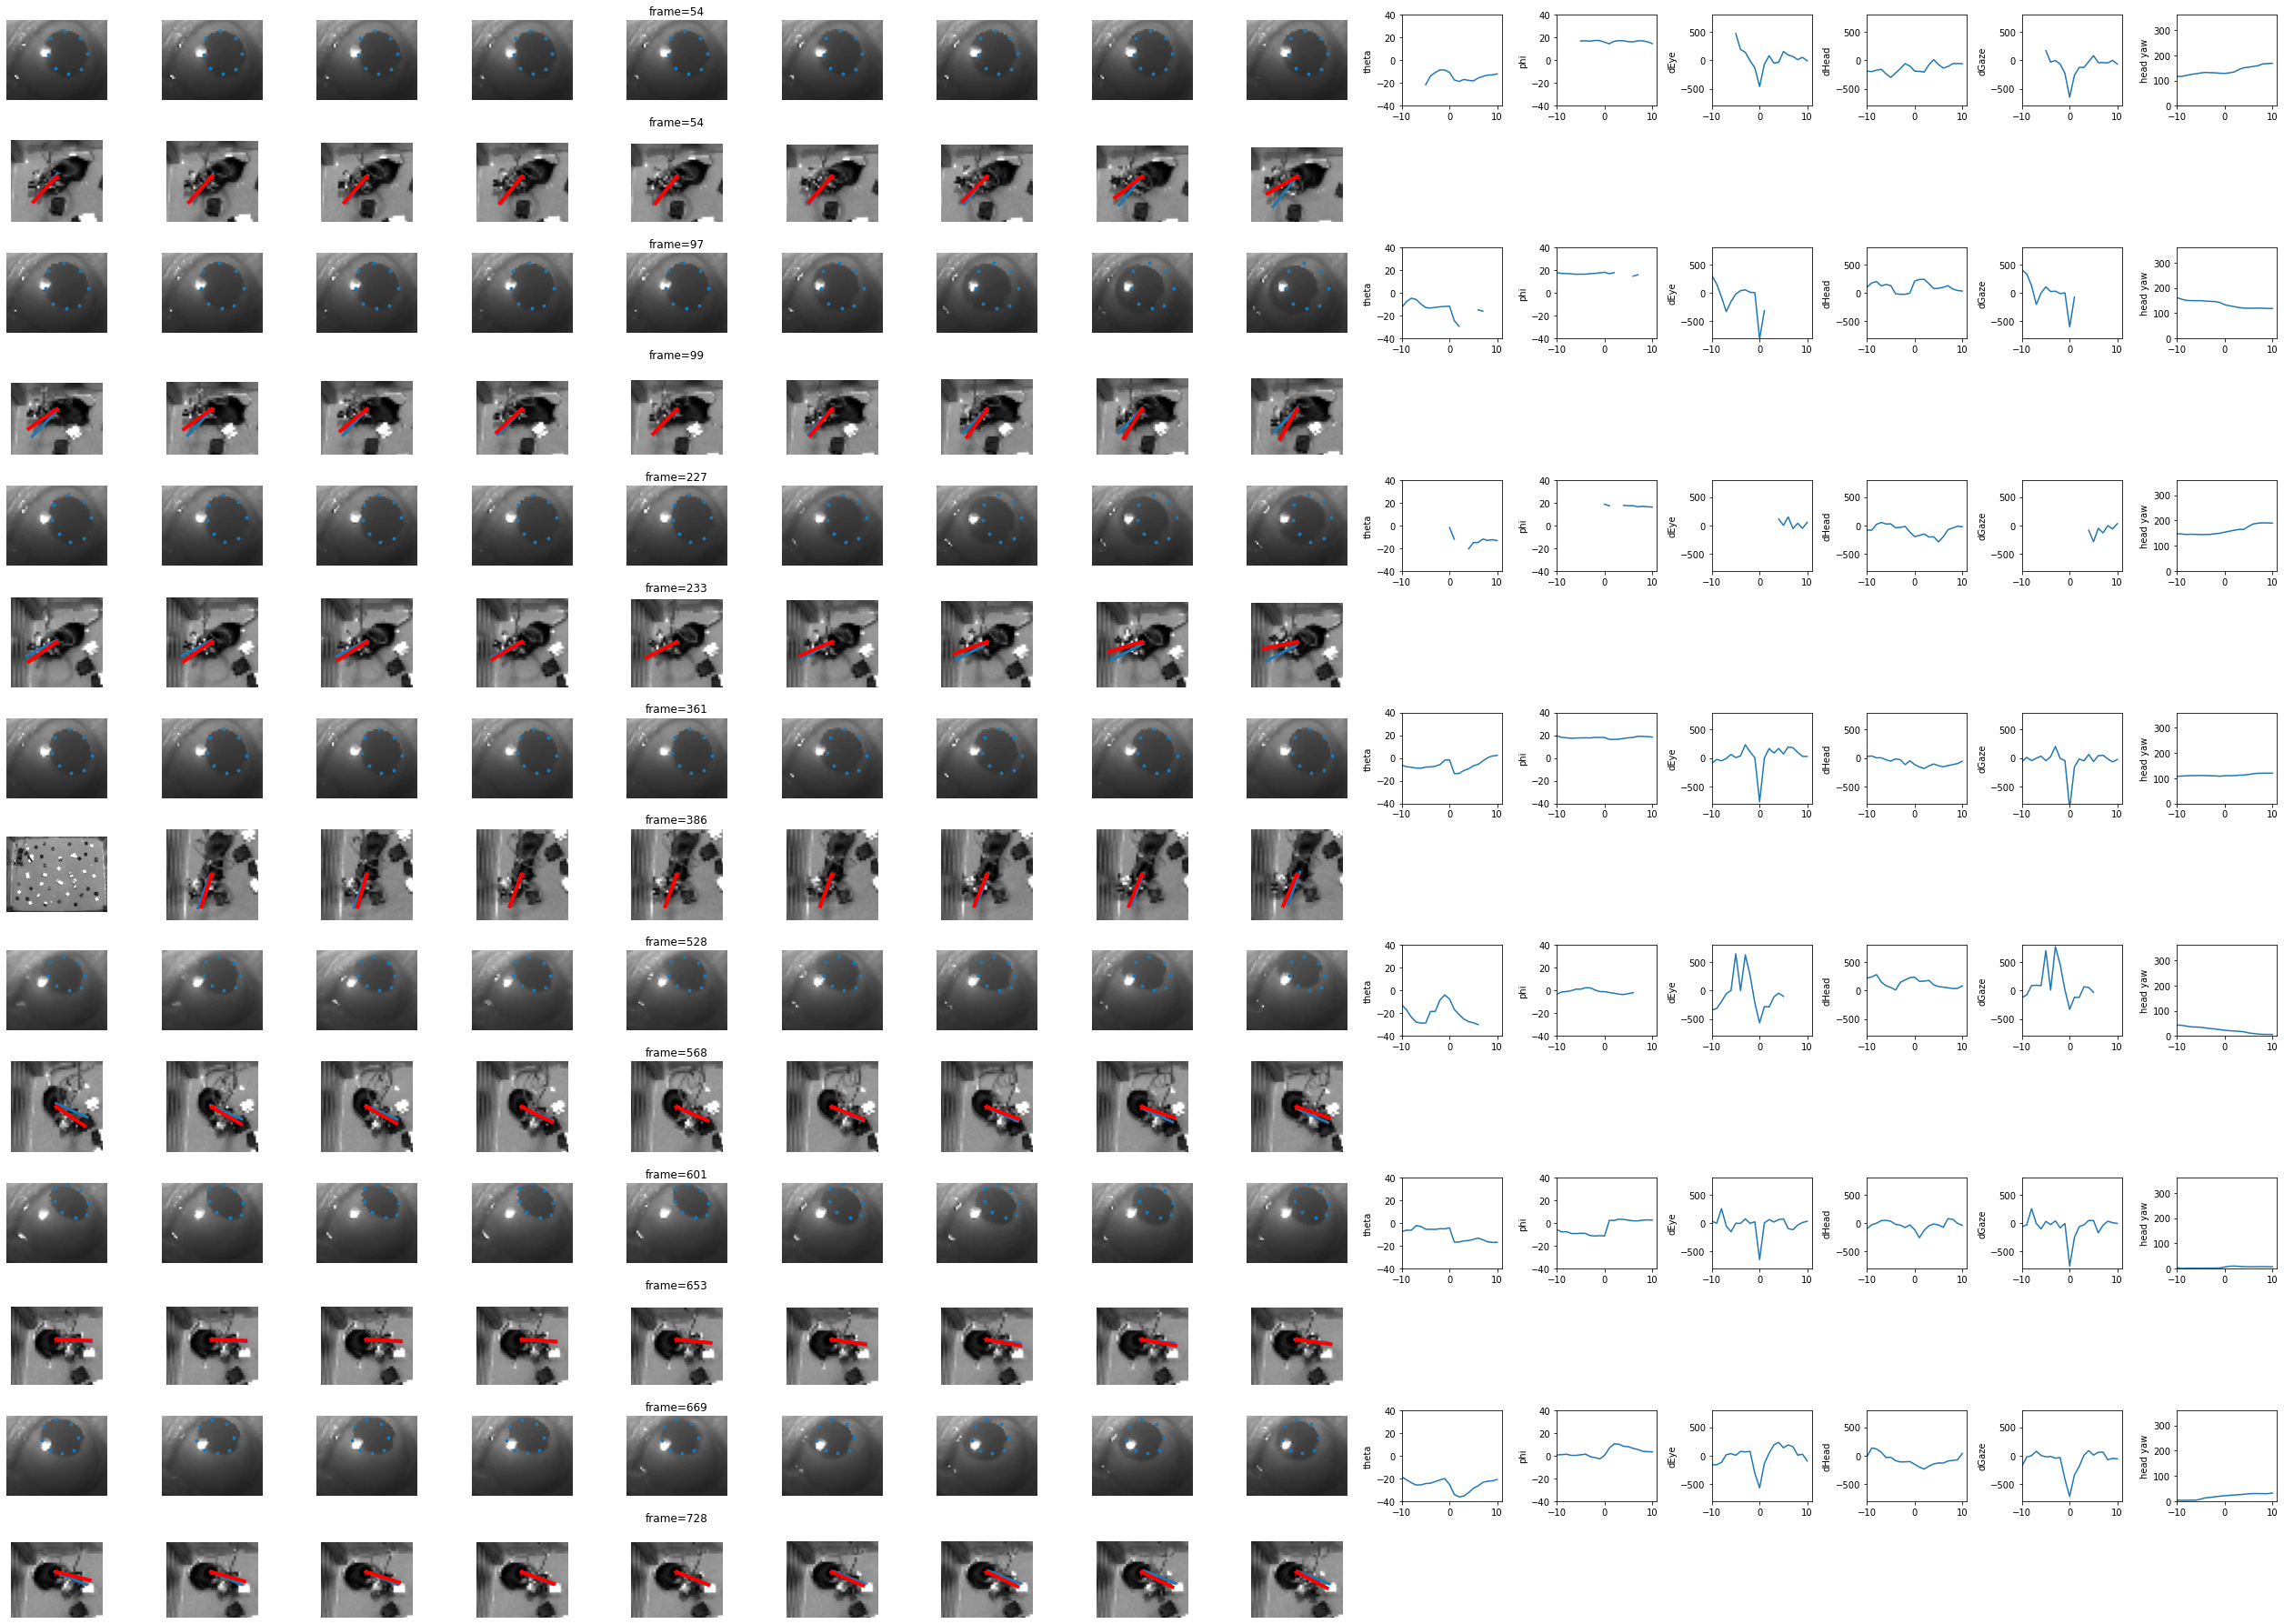

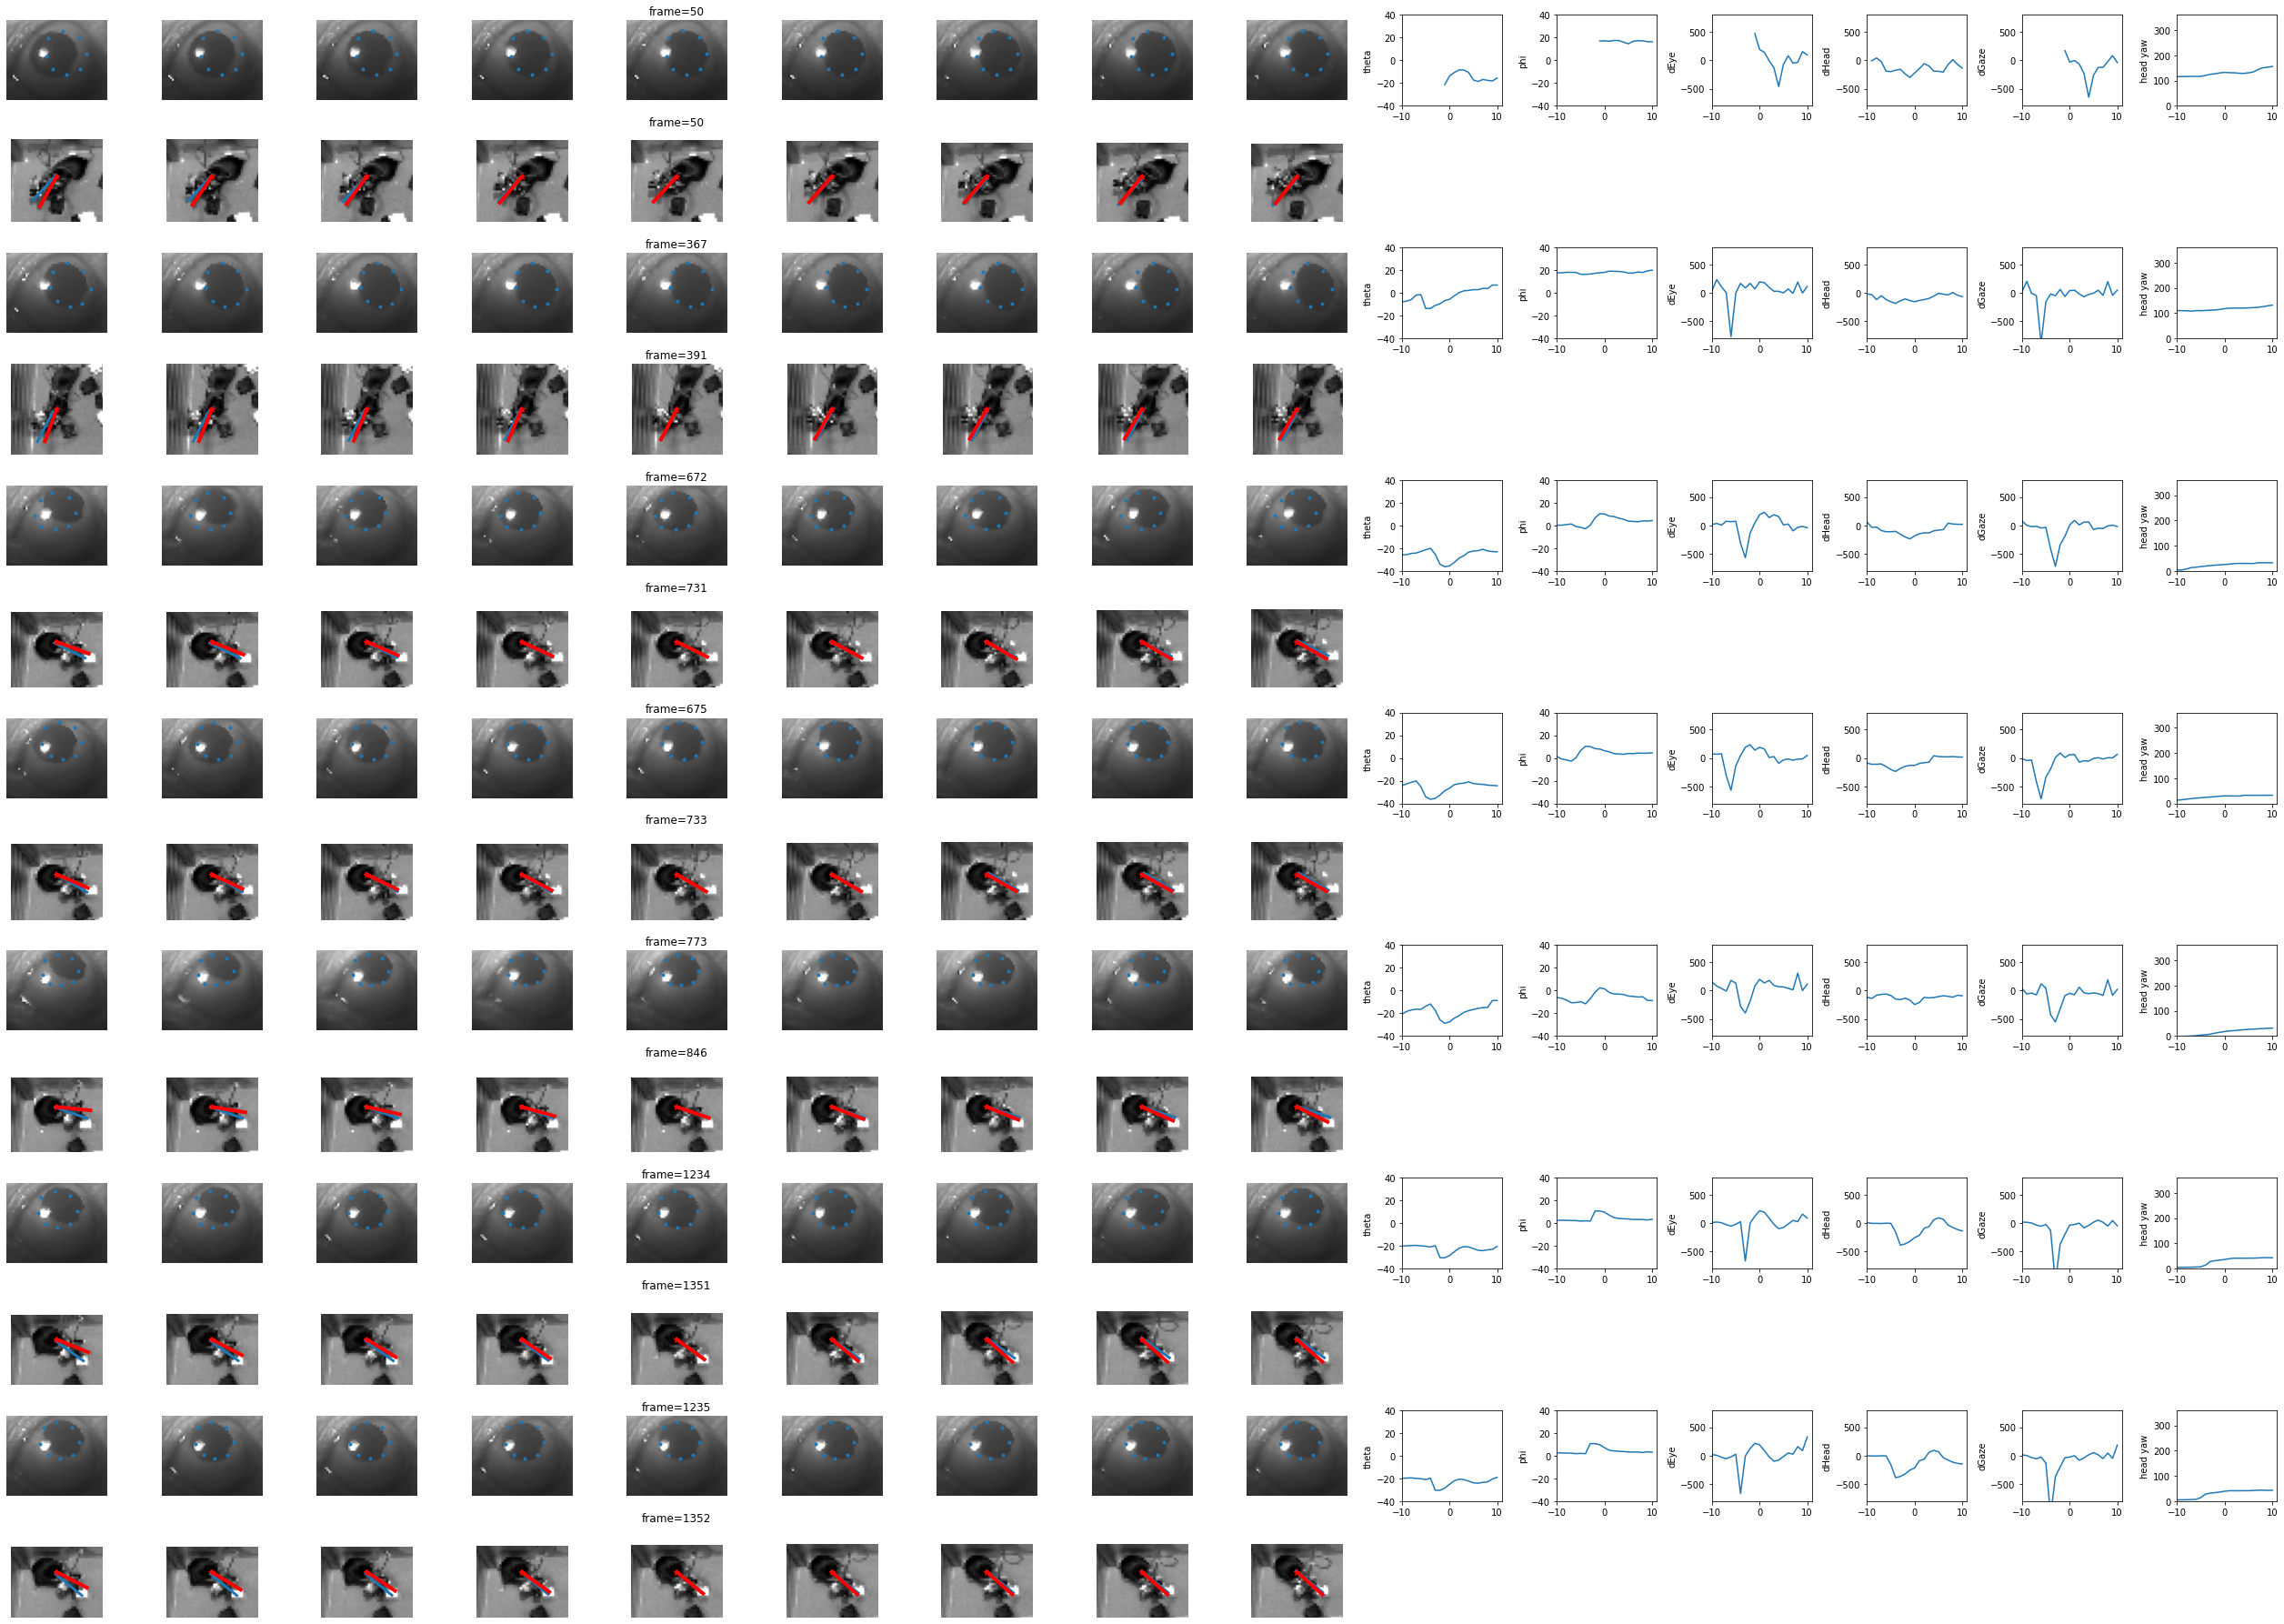

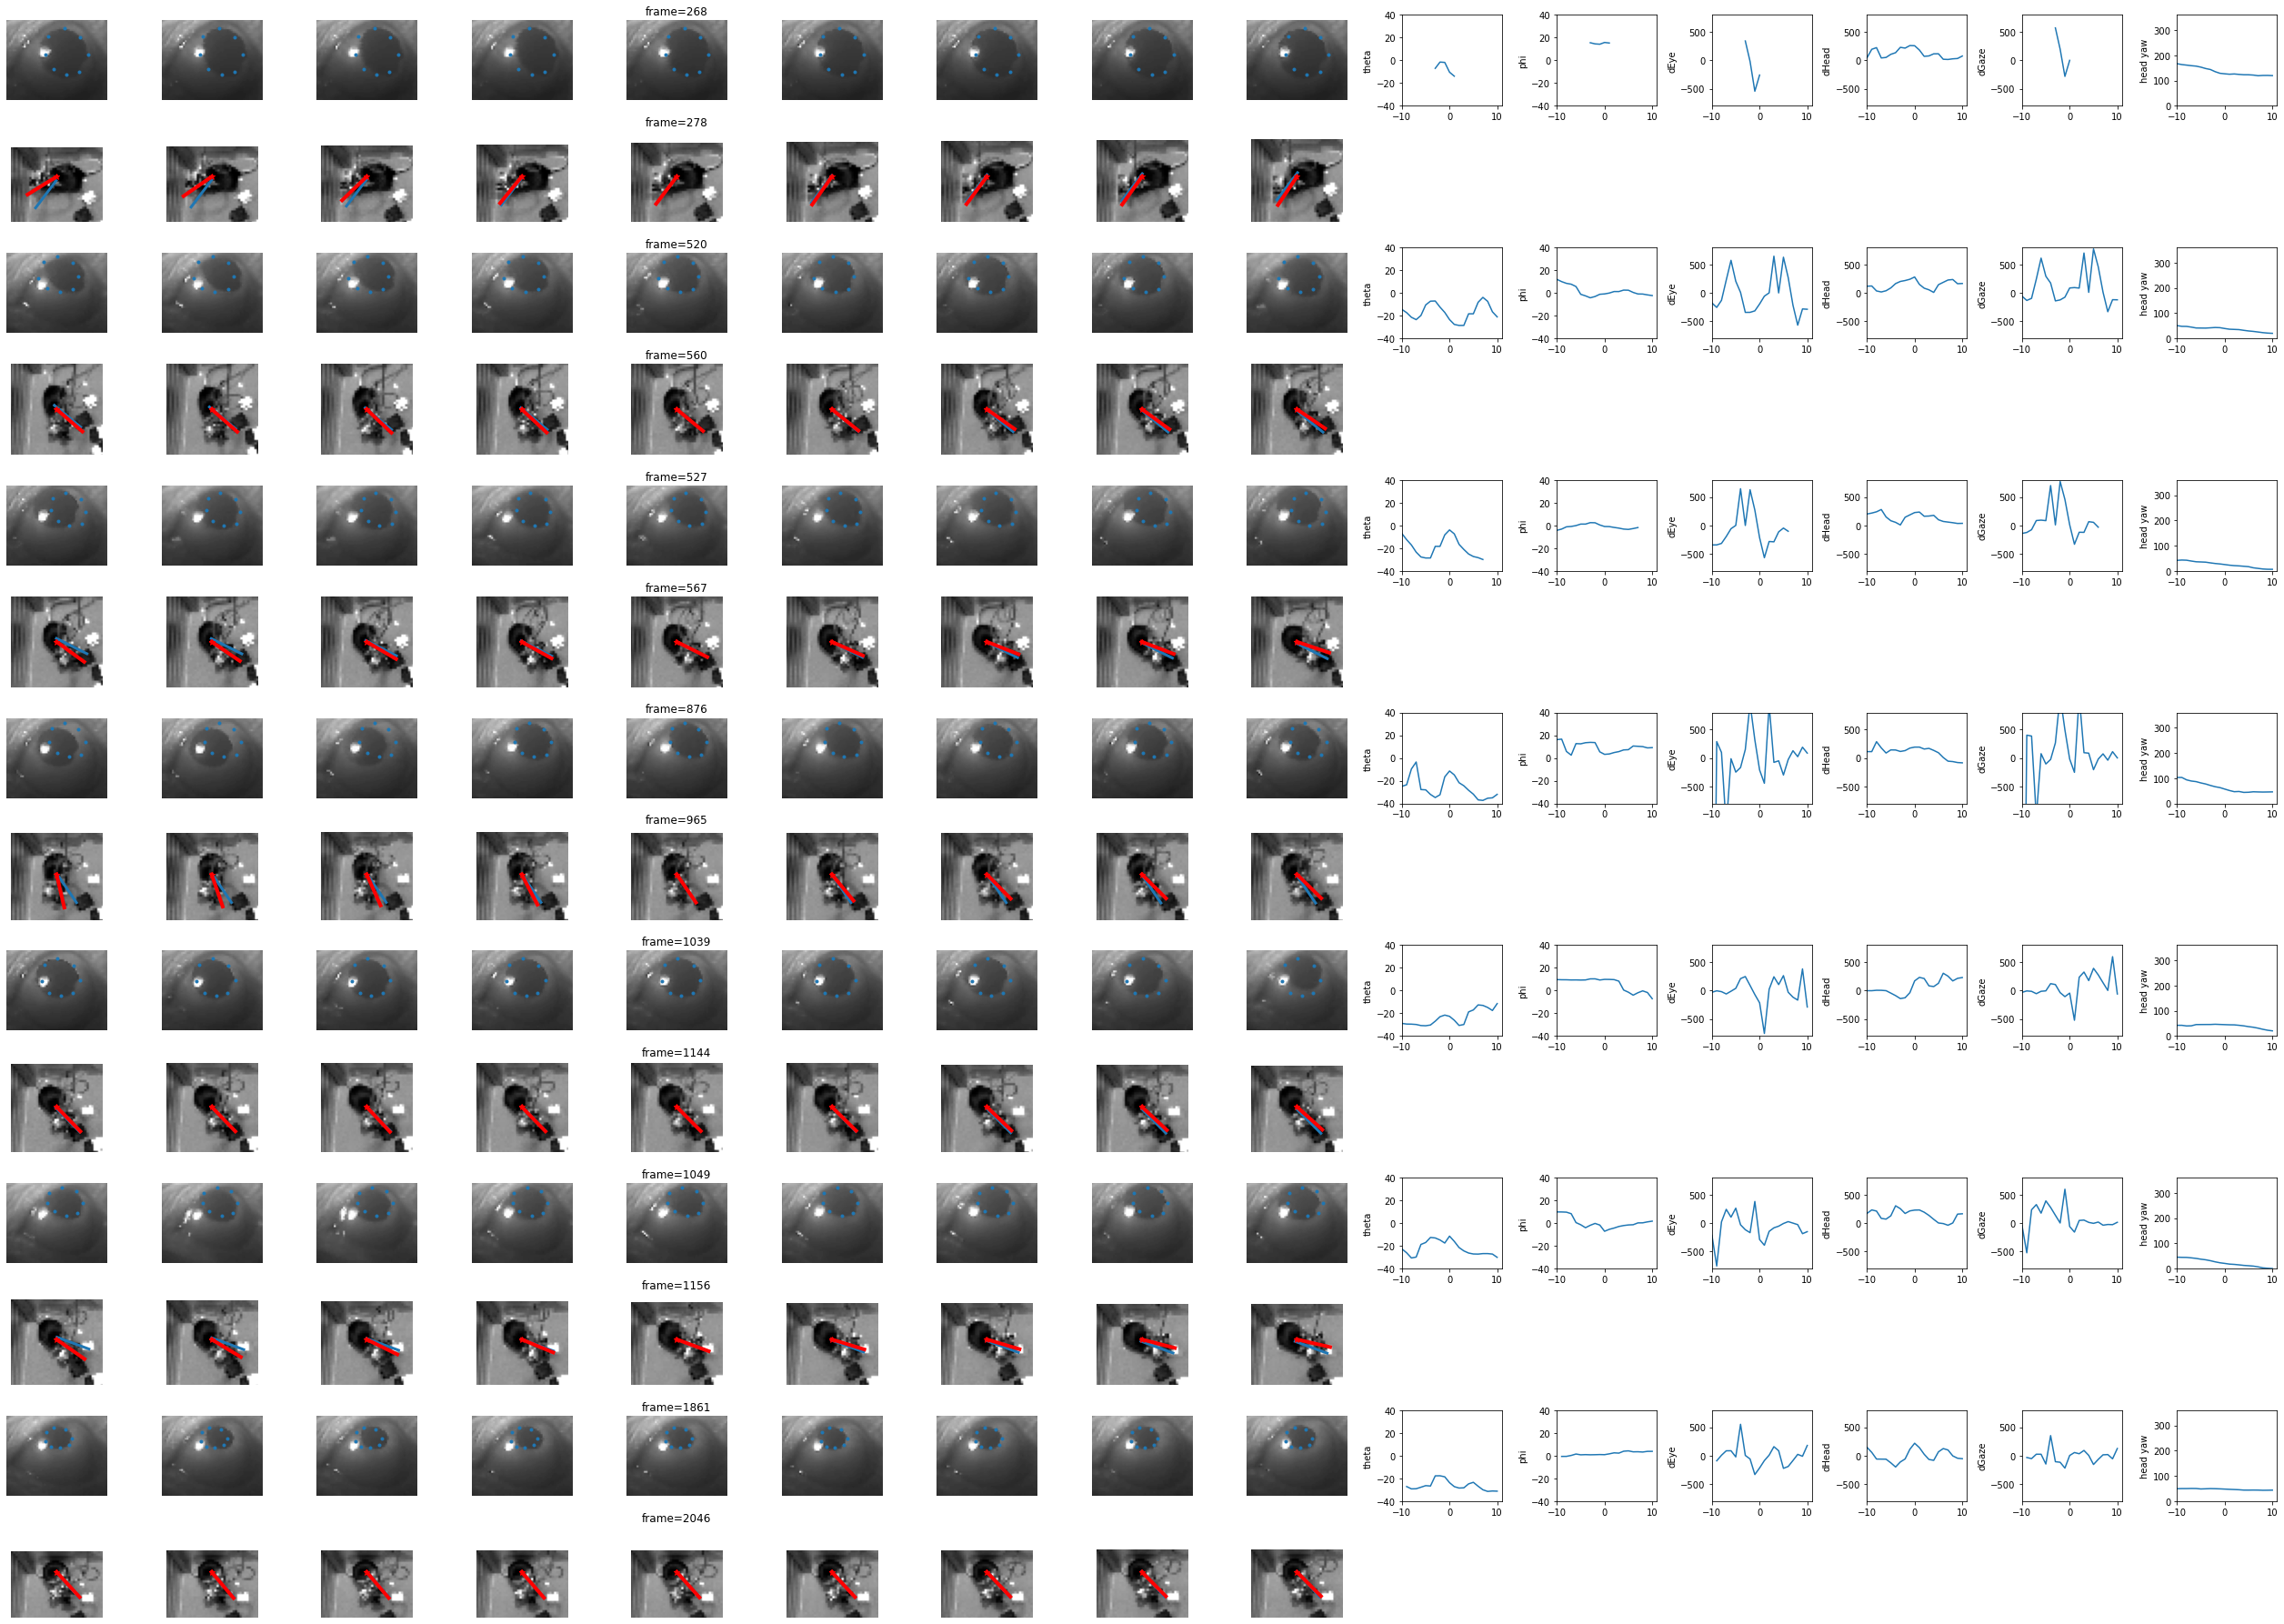

In [5]:
for fignum in range(4):
    if fignum == 0:
        # gaze-shift left deye saccade
        sthresh = 5/0.016
        direcdata = eyeT[(np.append(dEye, 0) > sthresh) & (np.append(dGaze,0) > sthresh)]
        sidestr = 'left'
        movtype = 'gaze-shift'
        
    elif fignum == 1:
        # gaze-shift right deye saccade
        sthresh = 5/0.016
        direcdata = eyeT[(np.append(dEye, 0) < -sthresh) & (np.append(dGaze, 0) < -sthresh)]
        sidestr = 'right'
        movtype = 'gaze-shift'
        
    if fignum == 2:
        # comp left deye saccade
        sthresh = 3/0.016
        gaze_sthresh = 1/0.016
        direcdata = eyeT[(np.append(dEye, 0) > sthresh) & (np.append(dGaze, 0) < gaze_sthresh)]
        sidestr = 'left'
        movtype = 'comp'
        
    elif fignum == 3:
        # comp right deye saccade
        sthresh = 3/0.016
        direcdata = eyeT[(np.append(dEye, 0) < -sthresh) & (np.append(dGaze, 0) > -gaze_sthresh)]
        sidestr = 'right'
        movtype = 'comp'

    plt.subplots(14, 15, figsize=(35,25))

    win = 20
    varnames = ['theta','phi','dEye','dHead','dGaze','head yaw']
    datavars = [theta, phi, dEye, dHead, dGaze, np.rad2deg(headang_interp)]

    for event in range(7):
        f = eyetime2frame[direcdata[event]+t0]
        fs = np.arange(f-4,f+5)

        fixindfactor = 0

        # eyecam
        for i, vidpanel in enumerate(np.arange(1,10)+(event*30)):
            visf = fs[i%9]
            plt.subplot(14,15,vidpanel)
            plt.imshow(eyevid[visf,:,:].astype(np.uint8), cmap='gray')
            plt.axis('off')
            plt.xlim([50,105]); plt.ylim([119,75])
            if visf == f:
                plt.title('frame='+str(visf))
            vispts = pts.sel(frame=f)
            for n in range(8):
                plt.plot(vispts.sel(point_loc='pt'+str(n+1)+'_x').values*0.25, vispts.sel(point_loc='pt'+str(n+1)+'_y').values*0.25, '.', color='tab:blue')

        # topcam
        for i, vidpanel in enumerate(np.arange(16,25)+(event*30)):
            topf = np.nanargmin(np.abs((topT+t0) - (direcdata[event]+t0)))
            topfs = np.arange(topf-4,topf+5)
            visf = topfs[i%9]
            plt.subplot(14,15,vidpanel)
            plt.imshow(topvid[visf,:,:].astype(np.uint8), cmap='gray')
            plt.axis('off')
            x = neckpos_x[visf]*0.25; y = neckpos_y[visf]*0.25; th = headang[visf]
            x_f = neckpos_x[topf]*0.25; y_f = neckpos_y[topf]*0.25; th_f = headang[topf]
            if ~np.isnan(x) and ~np.isnan(y) and ~np.isnan(th):
                plt.xlim([x-win,x+win]); plt.ylim([y+win,y-win])
                plt.plot([x_f,x_f+15*np.cos(th_f)], [y_f,y_f+15*np.sin(th_f)], '-', color='tab:blue', linewidth=3)
                plt.plot([x,x+15*np.cos(th)], [y,y+15*np.sin(th)], 'r-', linewidth=4)
                plt.plot(x,y,'r*',markersize=7)
            if visf == topf:
                plt.title('frame='+str(visf))
        for i, datapanel in enumerate(np.arange(10,16)+(event*30)):
            var = datavars[i%6]
            plt.subplot(14,15,datapanel)
            plt.plot(np.arange(-10,11), var[f-10:f+11])
            plt.xlim([-10,11])
            plt.ylabel(varnames[i])
            if varnames[i] == 'theta' or varnames[i] == 'phi':
                plt.ylim([-40,40])
            elif varnames[i] == 'dHead' or varnames[i] == 'dEye' or varnames[i] == 'dGaze':
                plt.ylim([-800,800])
            elif varnames[i] == 'head yaw':
                plt.ylim([0,360])
        for i, datapanel in enumerate(np.arange(25,31)+(event*30)):
            plt.subplot(14,15,datapanel)
            plt.axis('off')

    plt.tight_layout()
    plt.savefig('/home/niell_lab/Desktop/'+sidestr+'_'+movtype+'.pdf')